## 4. Fundamenta_hedge
买入股票，同时当大盘价格低于MA30时卖出1手股指对冲风险。

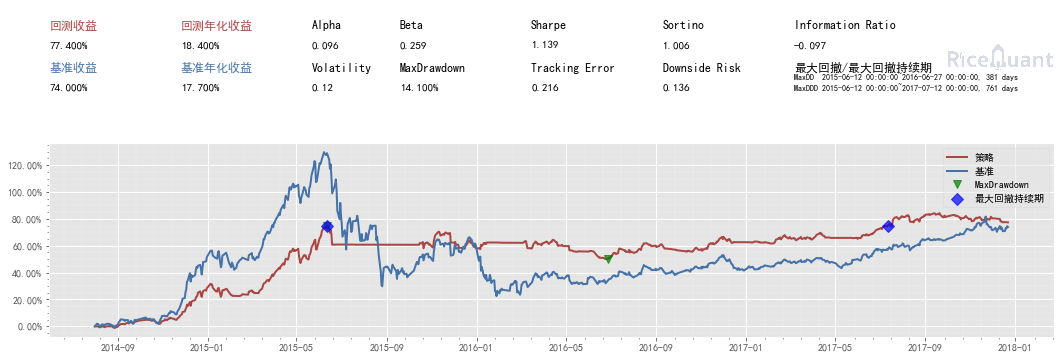

{'sys_analyser': {'benchmark_portfolio':               cash  market_value  static_unit_net_value  total_value  \
  date                                                                   
  2014-08-01  1374.8    1998625.20                  1.000   2000000.00   
  2014-08-04  1374.8    2038281.96                  1.000   2039656.76   
  2014-08-05  1374.8    2032902.30                  1.020   2034277.10   
  2014-08-06  1374.8    2027642.76                  1.017   2029017.56   
  2014-08-07  1374.8    1996960.68                  1.015   1998335.48   
  2014-08-08  1374.8    2000109.54                  0.999   2001484.34   
  2014-08-11  1374.8    2029470.30                  1.001   2030845.10   
  2014-08-12  1374.8    2022348.90                  1.015   2023723.70   
  2014-08-13  1374.8    2023936.20                  1.012   2025311.00   
  2014-08-14  1374.8    2004245.10                  1.013   2005619.90   
  2014-08-15  1374.8    2025429.12                  1.003   2026803.92   

In [1]:
import numpy as np
import talib as ta
import pandas as pd
import rqalpha
from rqalpha.api import *

#读取文件位置
def init(context):
    context.codes = pd.read_excel('factor.xlsx',index_col='date')
    context.hs300 = '000300.XSHG'
    context.stocks = []
    scheduler.run_weekly(find_pool,tradingday=1)
#     scheduler.run_weekly(find_pool,tradingday=3)

def find_pool(context, bar_dict):
    try:
        codes = context.codes.loc[context.now]
    except KeyError:
        return
    stocks = codes.index[codes == 1]
    context.stocks = stocks

def handle_bar(context, bar_dict):
    hedge(context)
    if can_trade(context):
        buy(context, bar_dict)

def buy(context, bar_dict):
    pool = context.stocks
    if pool is not None:
        stocks_len = len(pool)
        for stocks in context.portfolio.positions:
            if stocks not in pool:
                order_target_percent(stocks, 0)
        for codes in pool:
            order_target_percent(codes, 1.0/stocks_len)

def sell_all(context):
    for stock in context.portfolio.positions:
        order_target_percent(stock, 0)

def can_trade(context):
    try:
        hs300_price = history_bars(context.hs300,61,'1d','close')
        hs300_ma = ta.MA(hs300_price,40)
        if hs300_price[-1]<hs300_ma[-1]:
            sell_all(context)
            return False
        else:
            return True
    except KeyError:
        return

def hedge(context):
    hs300_price = history_bars(context.hs300,70,'1d','close')
    hs300_ma = ta.EMA(hs300_price,60)
    future = get_future_contracts("IF")[0]
    sell_qty = context.portfolio.positions[future].sell_quantity
    if  (hs300_price[-1]<hs300_ma[-1]) and (hs300_price[-2]>hs300_ma[-2]) and sell_qty==0:
        sell_open(future, 1)
    elif (hs300_price[-1]>hs300_ma[-1]) and (hs300_price[-2]<hs300_ma[-2]) and sell_qty>0:
        buy_close(future, 1)

config = {
  "base": {
    "start_date": "2014-08-01",
    "end_date": "2017-12-22",
    "accounts": {'stock':1000000, 'future':1000000},
    "benchmark": "000300.XSHG"
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

rqalpha.run_func(init=init, handle_bar=handle_bar, config=config)